# Can you predict when PieMan is directly (name or pronoun referring to him) mentioned in the story from Shirer Components?  
Step 1: Import shirer components for each subject in the narratives dataset  
Step 2: Define where pieman is mentioned  
Step 3-4: Prepare data, add lags to give more context (given that our event we are classifying is relatively rare)  
Step 5: GridSearch for best parameters  
Step 6-7: Print results for best performing models, plot precision-recall curve  

In [1]:
import h5py

subject_list = [
    "sub-002", "sub-003", "sub-004", "sub-005", "sub-006", "sub-007", "sub-008",
    "sub-009", "sub-010", "sub-011", "sub-012", "sub-013", "sub-014", "sub-015",
    "sub-016", "sub-017", "sub-018", "sub-019", "sub-020", "sub-023", "sub-024",
    "sub-025", "sub-026", "sub-027", "sub-028", "sub-029", "sub-030", "sub-031",
    "sub-032", "sub-033", "sub-034", "sub-035", "sub-036", "sub-037", "sub-039",
    "sub-040", "sub-041", "sub-042", "sub-043", "sub-044", "sub-045", "sub-046",
    "sub-047", "sub-048", "sub-049", "sub-050", "sub-051", "sub-052", "sub-053",
    "sub-054", "sub-055", "sub-057", "sub-058", "sub-059", "sub-060", "sub-061",
    "sub-062", "sub-063", "sub-064", "sub-065", "sub-066", "sub-067", "sub-070",
    "sub-071", "sub-072", "sub-073", "sub-074", "sub-075", "sub-076", "sub-077",
    "sub-078", "sub-079", "sub-080", "sub-081", "sub-082"
]

# Dictionary to store timeseries data per subject
timeseries_dict = {}

# Variable to store networks once
networks = None

for subj in subject_list:
    file_path = f'shirer_components/{subj}_desc-shirercomponents.h5'
    
    print(f"\nLoading subject {subj} from: {file_path}")
    
    with h5py.File(file_path, 'r') as f:
        # Load networks only once
        if networks is None:
            networks = f['network'][:]
            print("Loaded networks:", networks)
        
        # Load timeseries and store in dictionary
        data = f['timeseries'][:]
        timeseries_dict[subj] = data
        print(f"Timeseries shape for subject {subj}:", data.shape)


Loading subject sub-002 from: shirer_components/sub-002_desc-shirercomponents.h5
Loaded networks: [b'anteriorsalience' b'auditory' b'basalganglia' b'dorsaldmn'
 b'highervisual' b'language' b'leftcontrol' b'posteriorsalience'
 b'precuneus' b'primaryvisual' b'rightcontrol' b'sensorimotor'
 b'ventraldmn' b'visuospatial']
Timeseries shape for subject sub-002: (14, 279)

Loading subject sub-003 from: shirer_components/sub-003_desc-shirercomponents.h5
Timeseries shape for subject sub-003: (14, 279)

Loading subject sub-004 from: shirer_components/sub-004_desc-shirercomponents.h5
Timeseries shape for subject sub-004: (14, 279)

Loading subject sub-005 from: shirer_components/sub-005_desc-shirercomponents.h5
Timeseries shape for subject sub-005: (14, 279)

Loading subject sub-006 from: shirer_components/sub-006_desc-shirercomponents.h5
Timeseries shape for subject sub-006: (14, 279)

Loading subject sub-007 from: shirer_components/sub-007_desc-shirercomponents.h5
Timeseries shape for subject 

In [2]:
import numpy as np
# note TR 14 is position 0 (for the neural data)
# note TR 11 is position 0 (for the speech data, hemodynamic lag of 3 TRs aka 4.5 seconds)
# initialize with zeros
events = np.zeros(279)
# positions where pieman is mentioned
pieman = [33, 34, 35, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 102, 
          123, 134, 140, 183, 184, 186, 187, 196, 197, 202, 203, 
          204, 205, 207, 208, 240, 241, 243, 255, 252, 253, 256, 
          257, 258, 265, 266, 271, 272]
# make those positions 1s
events[pieman] = 1

In [3]:
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Concatenate data across subjects
X = []
y = []

for subj, data in timeseries_dict.items():
    data = data.T  # Fix: transpose to (timepoints, networks)
    
    if len(data) != len(events):
        print(f"Skipping subject {subj} due to length mismatch: {len(data)} vs {len(events)}")
        continue

    X.append(data)
    y.append(events)  # same for each subject if events is shared

# Stack into full dataset
X = np.vstack(X)  # shape: (num_subjects × T, 14)
y = np.concatenate(y)  # shape: (num_subjects × T,)

In [4]:
def add_lag_features(X, lags=[1, 2]):
    """Adds lagged features for each row of X. Pads with edge values."""
    padded = np.pad(X, ((max(lags), 0), (0, 0)), mode='edge')
    lagged = [padded[max(lags)-l : len(X)+max(lags)-l] for l in lags]
    return np.hstack([X] + lagged)

X_lagged = add_lag_features(X, lags=[1, 2])  # shape: (n_samples, 14 * 3)

In [5]:
# Use lagged features
X_train, X_test, y_train, y_test = train_test_split(
    X_lagged, y, test_size=0.1, random_state=50, stratify=y
)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

# Use F1 score for minority class
grid = GridSearchCV(
    SVC(probability=True, random_state=50),
    param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Best estimator
clf = grid.best_estimator_
print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [7]:
import pandas as pd

results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Display top 5 combinations
print(results_df[['params', 'mean_test_score', 'std_test_score']].head())

                                              params  mean_test_score  \
2  {'C': 1, 'class_weight': 'balanced', 'gamma': ...         0.344144   
5  {'C': 10, 'class_weight': 'balanced', 'gamma':...         0.340155   
4  {'C': 10, 'class_weight': 'balanced', 'gamma':...         0.339717   
3  {'C': 1, 'class_weight': 'balanced', 'gamma': ...         0.328208   
0  {'C': 0.1, 'class_weight': 'balanced', 'gamma'...         0.326686   

   std_test_score  
2        0.002660  
5        0.003964  
4        0.012027  
3        0.001190  
0        0.002981  



--- Threshold: 0.10 ---
              precision    recall  f1-score   support

         0.0       0.95      0.38      0.54      1778
         1.0       0.20      0.89      0.33       315

    accuracy                           0.46      2093
   macro avg       0.58      0.63      0.44      2093
weighted avg       0.84      0.46      0.51      2093

Confusion Matrix:
[[ 675 1103]
 [  35  280]]

--- Threshold: 0.20 ---
              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84      1778
         1.0       0.30      0.51      0.38       315

    accuracy                           0.75      2093
   macro avg       0.60      0.65      0.61      2093
weighted avg       0.81      0.75      0.77      2093

Confusion Matrix:
[[1403  375]
 [ 154  161]]

--- Threshold: 0.30 ---
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      1778
         1.0       0.39      0.17      0.23       315

    accuracy     

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/srv/co

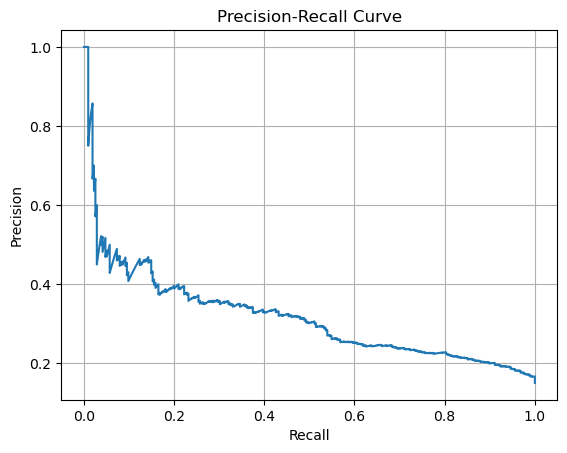

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities for class 1
y_prob = clf.predict_proba(X_test)[:, 1]

# Try several thresholds
thresholds = np.linspace(0.1, 0.9, 9)

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    print(f"\n--- Threshold: {t:.2f} ---")
    print(classification_report(y_test, y_pred_thresh))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_thresh))

# Optional: plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

In [ ]:
# Best results of either:

# --- Threshold: 0.20 ---
#               precision    recall  f1-score   support

#          0.0       0.90      0.79      0.84      1778
#          1.0       0.30      0.51      0.38       315

#     accuracy                           0.75      2093
#    macro avg       0.60      0.65      0.61      2093
# weighted avg       0.81      0.75      0.77      2093

# Confusion Matrix:
# [[1403  375]
#  [ 154  161]]

# --- Threshold: 0.30 ---
#               precision    recall  f1-score   support

#          0.0       0.87      0.96      0.91      1778
#          1.0       0.39      0.17      0.23       315

#     accuracy                           0.84      2093
#    macro avg       0.63      0.56      0.57      2093
# weighted avg       0.79      0.84      0.81      2093

# Confusion Matrix:
# [[1698   80]
#  [ 263   52]]